This jupyter notebook tries to predict solar flares in the next day based on the last N days using recurrent neural networks (NN) for binary (flare or not) classification.
It is divided in 4 parts:
* Loading libraries and data.
* Transforming the dataset and doing some feature engineering.
* Making and fiting the model.
* Checking the results.

# Forecasting solar flares using neural networks for classification
***


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               4480 non-null   object 
 1   USFLUX             4480 non-null   float64
 2   MEANGAM            4480 non-null   float64
 3   MEANGBT            4480 non-null   float64
 4   MEANGBZ            4480 non-null   float64
 5   MEANGBH            4480 non-null   float64
 6   MEANJZD            4480 non-null   float64
 7   TOTUSJZ            4480 non-null   float64
 8   MEANALP            4480 non-null   float64
 9   MEANJZH            4480 non-null   float64
 10  TOTUSJH            4480 non-null   float64
 11  ABSNJZH            4480 non-null   float64
 12  SAVNCPP            4480 non-null   float64
 13  MEANPOT            4480 non-null   float64
 14  TOTPOT             4480 non-null   float64
 15  MEANSHR            4480 non-null   float64
 16  SHRGT45            4480 

# Changing the dataframe to fit NN
***

In [3]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   DATE               4480 non-null   datetime64[ns, UTC]
 1   USFLUX             4480 non-null   float64            
 2   MEANGAM            4480 non-null   float64            
 3   MEANGBT            4480 non-null   float64            
 4   MEANGBZ            4480 non-null   float64            
 5   MEANGBH            4480 non-null   float64            
 6   MEANJZD            4480 non-null   float64            
 7   TOTUSJZ            4480 non-null   float64            
 8   MEANALP            4480 non-null   float64            
 9   MEANJZH            4480 non-null   float64            
 10  TOTUSJH            4480 non-null   float64            
 11  ABSNJZH            4480 non-null   float64            
 12  SAVNCPP            4480 non-null   float64      

In [4]:
# Analyze flare distribution over time

# Number of C, M, and X flares per year
sum_columns = ['Flares: C', 'Flares: M', 'Flares: X']
df_flares = df.groupby(df['DATE'].dt.year)[sum_columns].agg(['sum'])
#df_flares = df_flares.reset_index()
print(df_flares)

# Number of days with M or X flares (count should be 365 or 366 for leap years)
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with M or X flare distribution by year:")
print(yearly_flares)

     Flares: C Flares: M Flares: X
           sum       sum       sum
DATE                              
2010      88.0       8.0       0.0
2011    1199.0     111.0       8.0
2012    1335.0     129.0       7.0
2013    1357.0      99.0      12.0
2014    1798.0     208.0      16.0
2015    1377.0     125.0       2.0
2016     321.0      16.0       0.0
2017     243.0      39.0       4.0
2018      13.0       0.0       0.0
2019      32.0       0.0       0.0
2020      85.0       2.0       0.0
2021     407.0      28.0       2.0
2022    2077.0     184.0       7.0
2023     119.0      23.0       3.0

Days with M or X flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [5]:
# function to created the lagged features
def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict the next day's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: next day's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [6]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 3 to 4478
Data columns (total 95 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   USFLUX_lag1             4476 non-null   float64            
 1   MEANGAM_lag1            4476 non-null   float64            
 2   MEANGBT_lag1            4476 non-null   float64            
 3   MEANGBZ_lag1            4476 non-null   float64            
 4   MEANGBH_lag1            4476 non-null   float64            
 5   MEANJZD_lag1            4476 non-null   float64            
 6   TOTUSJZ_lag1            4476 non-null   float64            
 7   MEANALP_lag1            4476 non-null   float64            
 8   MEANJZH_lag1            4476 non-null   float64            
 9   TOTUSJH_lag1            4476 non-null   float64            
 10  ABSNJZH_lag1            4476 non-null   float64            
 11  SAVNCPP_lag1            4476 non-null   float64 

In [7]:
# chronological split is important for time series, so let's sort by DATE
lagged_data = lagged_data.sort_values('DATE').reset_index(drop=True)
assert lagged_data['DATE'].is_monotonic_increasing

print(lagged_data.head())

    USFLUX_lag1  MEANGAM_lag1  MEANGBT_lag1  MEANGBZ_lag1  MEANGBH_lag1  \
0  2.737004e+21     32.654695    114.207593    116.857353     50.317212   
1  3.460735e+21     29.845298    111.707230    113.253585     47.297438   
2  4.497098e+21     32.732238    114.995095    116.684410     53.376813   
3  3.672238e+21     31.230443    121.314292    122.012431     51.513595   
4  3.735080e+21     31.663927    119.169119    119.802653     50.661772   

   MEANJZD_lag1  TOTUSJZ_lag1  MEANALP_lag1  MEANJZH_lag1  TOTUSJH_lag1  ...  \
0      0.219577  3.095129e+12     -0.002852     -0.000701    147.333590  ...   
1      0.145063  3.903967e+12     -0.015477     -0.005461    192.675370  ...   
2      0.285346  5.270056e+12     -0.019851     -0.008012    271.850544  ...   
3      0.013373  4.616568e+12     -0.015028     -0.005155    234.575933  ...   
4      0.018493  4.679853e+12     -0.004378     -0.001769    219.506435  ...   

   Radio Flux 10.7cm_lag3  Sunspot Number_lag3  Sunspot Area_lag3  \

# Fitting the model
***

In [8]:
# let's check all columns to drop some on the next step
print(lagged_data.columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1', 'Sunspot Area_lag1',
       'New Regions_lag1', 'Flares: C_lag1', 'Flares: M_lag1',
       'Flares: X_lag1', 'flare_missing_lag1', 'USFLUX_lag2', 'MEANGAM_lag2',
       'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2', 'MEANJZD_lag2',
       'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2', 'TOTUSJH_lag2',
       'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2', 'TOTPOT_lag2',
       'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2', 'xrs_A_mean_lag2',
       'xrs_A_min_lag2', 'xrs_A_max_lag2', 'xrs_B_mean_lag2', 'xrs_B_min_l

In [9]:
# Separate features and target
# I started using the Flares: C/M/X features, and it is very useful, but it may leak information from the future.
# DATE may not be a problem or leak information, but I am excluding it just to be sure
#feature_cols = [col for col in lagged_data.columns if col not in ['DATE', 'target']] 
feature_cols = [col for col in lagged_data.columns if col not in [
    'DATE', 
    'target', 
    'Flares: C_lag1', 
    'Flares: M_lag1', 
    'Flares: X_lag1',
    'Flares: C_lag2', 
    'Flares: M_lag2', 
    'Flares: X_lag2',
    'Flares: C_lag3', 
    'Flares: M_lag3', 
    'Flares: X_lag3'
    ]]
X = lagged_data[feature_cols].values
y = lagged_data['target'].values

In [10]:
# let's check all columns
print(lagged_data[feature_cols].columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1', 'Sunspot Area_lag1',
       'New Regions_lag1', 'flare_missing_lag1', 'USFLUX_lag2', 'MEANGAM_lag2',
       'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2', 'MEANJZD_lag2',
       'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2', 'TOTUSJH_lag2',
       'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2', 'TOTPOT_lag2',
       'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2', 'xrs_A_mean_lag2',
       'xrs_A_min_lag2', 'xrs_A_max_lag2', 'xrs_B_mean_lag2', 'xrs_B_min_lag2',
       'xrs_B_max_lag2', 'Radio Flux 10.7cm_lag2', 'Sun

In [11]:
# Split into train and test sets

# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 3580
Test samples: 896

Class distribution in training set:
Percentage of positive cases in train: 12.09%

Class distribution in test set:
Percentage of positive cases in test: 13.62%


In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# you can just load the model if already trained and not run the grid search and best model again
try:
    model = load_model('../data/flares_keras_NN.keras')
except:
    print("No saved model found, proceeding to train a new model.")

No saved model found, proceeding to train a new model.


In [ ]:
# custom metric
def f2_score(y_true, y_pred):
    y_pred = tf.round(y_pred)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    beta_sq = 4.0  # 2^2
    num = (1.0 + beta_sq) * tp
    den = (1.0 + beta_sq) * tp + beta_sq * fn + fp + 1e-8

    return num / den

In [15]:
# Function to create the NN model
def create_model(n_features, layer1_units=128, layer2_units=64, 
                 dropout_rate=0.3, learning_rate=0.001):
    """Create model with configurable hyperparameters"""
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(layer1_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(layer2_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[f2_score, 'Recall', 'AUC']
    )
    
    return model

In [16]:
# Function to create the randomized search for hyperparameter tuning
def randomized_search(X_train_scaled, y_train, n_iter=20):
    """Random search over hyperparameters"""
    
    # Define hyperparameter ranges
    param_distributions = {
        'layer1_units': [64, 128, 256, 512],
        'layer2_units': [32, 64, 128, 256],
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
        'batch_size': [16, 32, 64, 128]
    }
    
    n_features = X_train_scaled.shape[1]
    
    # Compute class weights for imbalanced dataset
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )))
    
    best_score = 0
    best_params = {}
    results = []
    
    print(f"Testing {n_iter} random combinations...")
    
    for i in range(n_iter):
        # Random sample from each parameter
        params = {
            'layer1_units': np.random.choice(param_distributions['layer1_units']),
            'layer2_units': np.random.choice(param_distributions['layer2_units']),
            'dropout_rate': np.random.choice(param_distributions['dropout_rate']),
            'learning_rate': np.random.choice(param_distributions['learning_rate']),
            'batch_size': np.random.choice(param_distributions['batch_size'])
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing: {params}")
        
        # Create model (exclude batch_size from model creation)
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(n_features=n_features, **model_params)
        
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0,
            class_weight=class_weights
        )
        
        # Get best validation
        val_f2 = max(history.history['val_f2_score'])
        print(f"  -> Val F2: {val_f2:.4f}")
        
        # Store results
        results.append({**params, 'val_f2': val_f2})
        
        # Update best
        if val_f2 > best_score:
            best_score = val_f2
            best_params = params
    
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"  Best Validation F2: {best_score:.4f}")
    
    return best_params, best_score, results

In [17]:
# Search for the best hyperparameters
best_params, best_score, results = randomized_search(
    X_train_scaled, 
    y_train, 
    n_iter=100
)

Testing 100 random combinations...

[1/100] Testing: {'layer1_units': np.int64(64), 'layer2_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(64)}
  -> Val F2: 0.0041

[2/100] Testing: {'layer1_units': np.int64(512), 'layer2_units': np.int64(256), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64)}
  -> Val F2: 0.0044

[3/100] Testing: {'layer1_units': np.int64(128), 'layer2_units': np.int64(32), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(128)}
  -> Val F2: 0.0076

[4/100] Testing: {'layer1_units': np.int64(64), 'layer2_units': np.int64(32), 'dropout_rate': np.float64(0.5), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(16)}
  -> Val F2: 0.0040

[5/100] Testing: {'layer1_units': np.int64(512), 'layer2_units': np.int64(256), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(1

In [18]:
# Get number of features
n_features = X_train_scaled.shape[1]

# Create the final model with best parameters
model = Sequential([
    Input(shape=(n_features,)),
    Dense(best_params['layer1_units'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['layer2_units'], activation='relu'),
    Dense(1, activation='sigmoid')
])

In [19]:
# Compile with best learning rate
model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=[f2_score, 'Recall', 'AUC']
)

In [20]:
# Compute class weights for imbalanced dataset
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

In [21]:
# Train the best model
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/50


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - AUC: 0.6434 - Recall: 0.3796 - f2_score: 0.3102 - loss: 0.7655 - val_AUC: 0.1916 - val_Recall: 0.0000e+00 - val_f2_score: 0.0094 - val_loss: 0.4175
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7593 - Recall: 0.8125 - f2_score: 0.3360 - loss: 0.6567 - val_AUC: 0.1902 - val_Recall: 0.0000e+00 - val_f2_score: 0.0093 - val_loss: 0.3918
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7870 - Recall: 0.8472 - f2_score: 0.3421 - loss: 0.6308 - val_AUC: 0.1811 - val_Recall: 0.0000e+00 - val_f2_score: 0.0090 - val_loss: 0.3309
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7930 - Recall: 0.8426 - f2_score: 0.3394 - loss: 0.6192 - val_AUC: 0.1483 - val_Recall: 0.0000e+00 - val_f2_score: 0.0087 - val_loss: 0.2728
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7980 - Recall: 0.8241 - f2_score: 0.3349 - loss: 0.6063 - val_AUC: 0.1441 - val_Recall: 0.0000e+00 - val_f2_score: 0.0083 - val_loss: 0.2275
Epoch 6/50

In [22]:
# evaluate
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.44380638003349304, 'compile_metrics': 0.2275797575712204}


In [23]:
# Save the best model
model.save("../data/flares_keras_NN.keras")
print("Best model saved to ../data/flares_keras_NN.keras")

Best model saved to ../data/flares_keras_NN.keras


In [24]:
# Predict
y_pred_proba = model.predict(X_test_scaled).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# Results
***

In [25]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2_score, f1_score, recall, avg_precision, roc_auc]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


Confusion Matrix:
[[597 177]
 [ 39  83]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       774
         1.0       0.32      0.68      0.43       122

    accuracy                           0.76       896
   macro avg       0.63      0.73      0.64       896
weighted avg       0.85      0.76      0.79       896


Evaluation Metrics:
       Metric  Score
           F2 0.5548
           F1 0.4346
       Recall 0.6803
Avg Precision 0.4223
      ROC AUC 0.8202


In [26]:
# Analyze different classification thresholds
print("\nThreshold Analysis:")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold Analysis:

Threshold = 0.3
  TP: 107, FP: 293, TN: 481, FN: 15
  Precision: 0.268, Recall: 0.877

Threshold = 0.4
  TP: 96, FP: 236, TN: 538, FN: 26
  Precision: 0.289, Recall: 0.787

Threshold = 0.5
  TP: 83, FP: 177, TN: 597, FN: 39
  Precision: 0.319, Recall: 0.680

Threshold = 0.6
  TP: 68, FP: 112, TN: 662, FN: 54
  Precision: 0.378, Recall: 0.557

Threshold = 0.7
  TP: 43, FP: 59, TN: 715, FN: 79
  Precision: 0.422, Recall: 0.352



Visualization saved as 'solar_flare_NN_results.png'


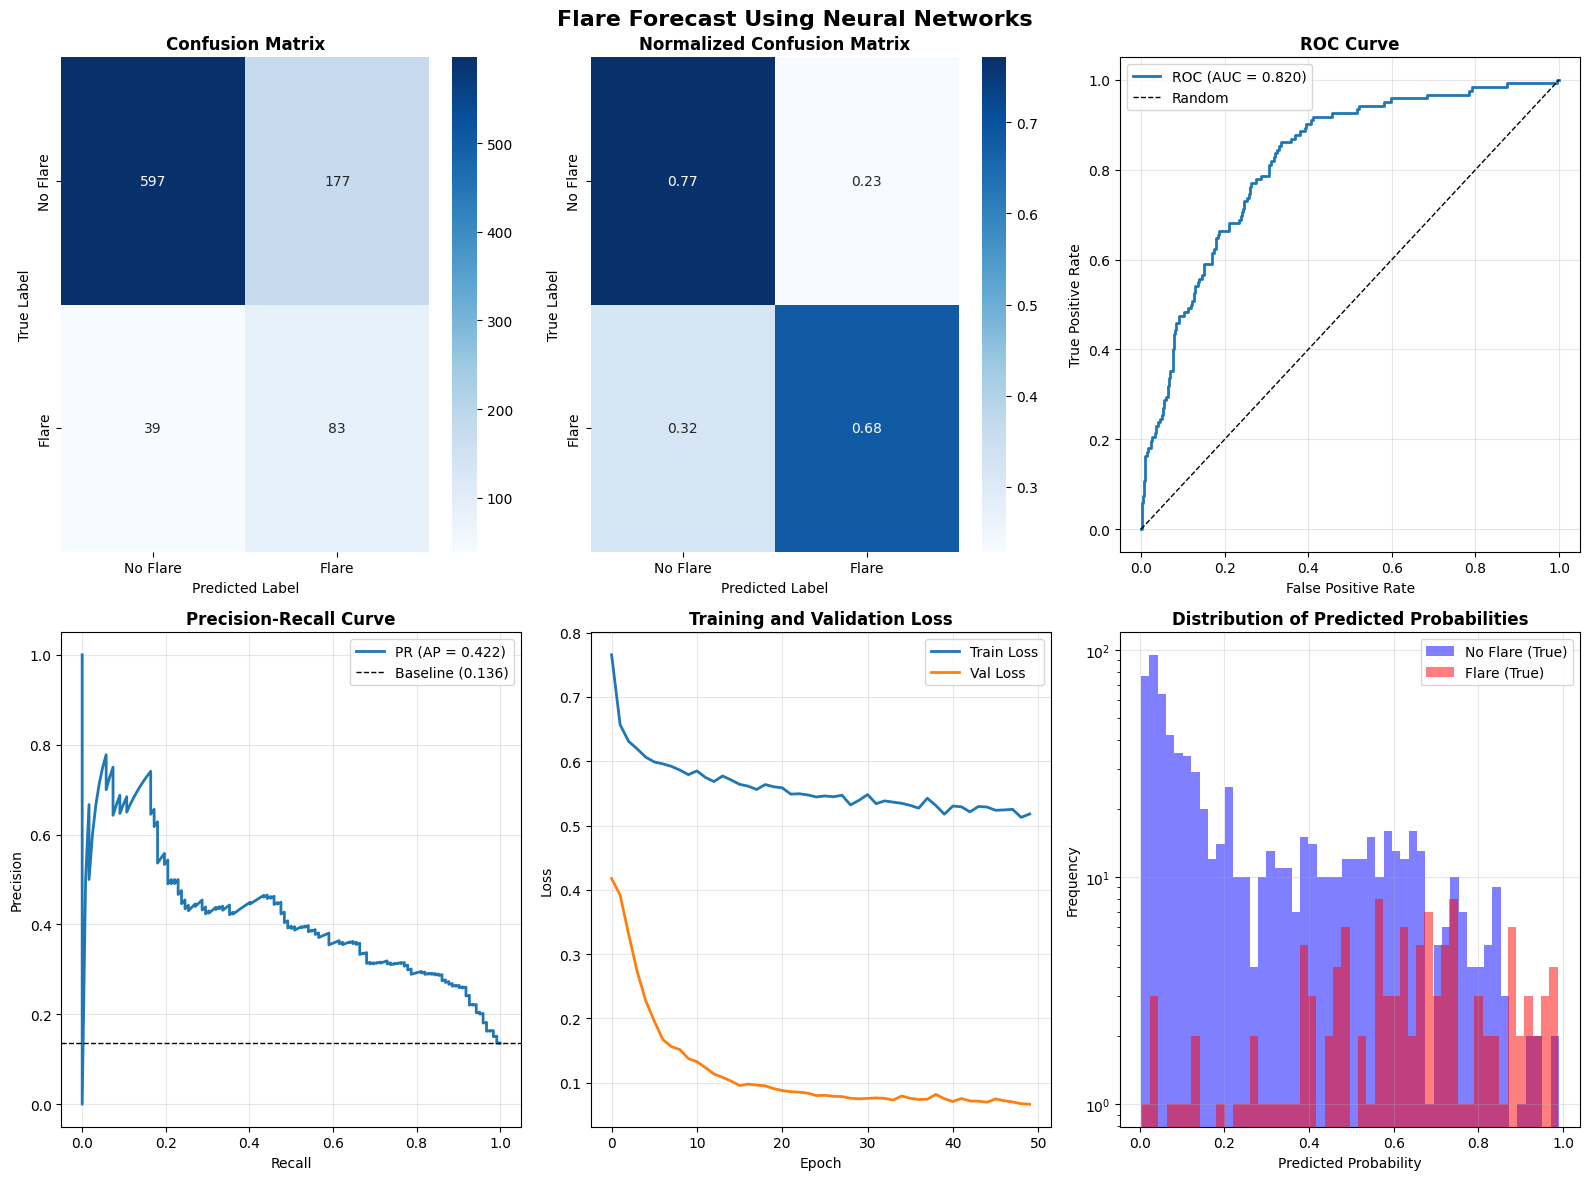

In [27]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Neural Networks', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Training and Validation Loss
if 'history' in locals():
    hist = history.history
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax5.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/solar_flare_NN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_NN_results.png'")
plt.show()